<a href="https://colab.research.google.com/github/artvanila/data_projects/blob/main/T_Mobile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aircrash Analysis

## Introduction

Let's analyze the aircrash dataset and find out the following:


*   Identification of the most dangerous operator.
*   Identification of the most often crash cause.  
*   Is the most often crash cause the most dangerous one as well? If not which one is the most dangerous?
*   Which variable (day / night, season of the year …)  is the most important for prediction crash cause?
*   Find any interesting trends/behaviors that you encounter when you analyze the dataset.

Before starting the research, we will import the necessary libraries and create functions to be used in the project.

In [110]:
import pandas as pd

In [111]:
import seaborn as sns

In [112]:
import matplotlib.pyplot as plt

In [113]:
from google.colab import drive

In [114]:
from scipy.stats import chi2_contingency

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [116]:
import os

In [117]:
import re

In [118]:
import random

In [119]:
import numpy as np

In [120]:
import plotly.express as px

In [121]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [122]:
# Adjust the path according to the dataset location, otherwise, the notebook will not work.
file_path_accidents = '/content/drive/MyDrive/Researches/TM/Airplane_Crashes_Since_1908.csv'

In [123]:
def primary_analysis(df):

    print("Information about the dataframe:")
    print(df.info())

    print("\nFirst 5 rows of the dataframe:")
    print(df.head())

    print("\nDescription of numerical columns:")
    print(df.describe())

    print("\nNumber of duplicate entries in the dataset:")
    print(df.duplicated().sum())

    print("\nNumber of missing values in the dataset:")
    print(df.isna().sum())

    print("\nFrequency distributions for categorical columns:")

    for column in df.select_dtypes(include=['object', 'category']).columns:
        print(f"\nColumn '{column}':")
        print(df[column].value_counts())

In [124]:
def data_loss(df, df_raw, column_name='name'):
    # Absolute loss
    loss_absolute = df_raw[column_name].count() - df[column_name].count()

    # Relative loss percentage
    loss_relative = 100 - (df[column_name].count() / df_raw[column_name].count() * 100)
    loss_relative = round(loss_relative, 2)

    # Convert to string and add '%' symbol
    loss_relative = str(loss_relative) + '%'

    print(f'Absolute data loss in column {column_name}: {loss_absolute}')
    print(f'Relative data loss in column {column_name}: {loss_relative}')

In [125]:
df = pd.read_csv(file_path_accidents)

In [126]:
df_raw = pd.read_csv(file_path_accidents)

In [127]:
primary_analysis(df)

Information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5268 non-null   object 
 1   Time          3049 non-null   object 
 2   Location      5248 non-null   object 
 3   Operator      5250 non-null   object 
 4   Flight #      1069 non-null   object 
 5   Route         3561 non-null   object 
 6   Type          5241 non-null   object 
 7   Registration  4933 non-null   object 
 8   cn/In         4040 non-null   object 
 9   Aboard        5246 non-null   float64
 10  Fatalities    5256 non-null   float64
 11  Ground        5246 non-null   float64
 12  Summary       4878 non-null   object 
dtypes: float64(3), object(10)
memory usage: 535.2+ KB
None

First 5 rows of the dataframe:
         Date   Time                            Location  \
0  09/17/1908  17:18                 Fort Myer, Virginia   
1  

Let's start with column descriptions:

*   `Date` – the recorded date of the incident.
*   `Time` – the exact or approximate time of the incident (if known).
*   `Location` – the city, country, or coordinates where the crash occurred.
*   `Operator` – the airline or organization operating the aircraft.
*   `Flight` – the flight identification number (if applicable).
*   `Route` – the flight path (e.g., Moscow – Saint Petersburg) or the purpose of the flight (e.g., training, sightseeing, test flight).
*   `Type` – the type/model of aircraft involved.
*   `Registration` – the unique aircraft registration number (e.g., I-TAVI).
*   `Cn/In` – the aircraft’s factory-assigned construction number (Construction Number).
*   `Aboard` – the total number of passengers and crew members.
*   `Fatalities` – the number of deaths among those on the aircraft.
*   `Ground` – the number of casualties among people not on the aircraft (e.g., if the plane crashed into a building or road).
*   `Summary` – a brief description of the incident.

Based on the initial data analysis, several key preprocessing steps have been identified (each of these aspects will be examined in detail in the next chapter):

1.   Column names standardization – renaming columns to a Python-friendly format for consistency and ease of use.
2.   Data types correction – identifying columns that require type conversion (e.g., Date and Time should be in datetime format, not object).
3.   Missing values correction – detecting missing values in columns and determining the appropriate approach to fill or remove them.
4.   Duplicate detection – while no obvious duplicates are present, it is necessary to check for hidden duplicates by analyzing unique values across key columns
5.   Feature Engineering – ensuring that the cleaned dataset is ready for answering research questions and creating new variables from existing data
6.   Analyzing quantitative data – checking Board, Fatalities, Ground for outliers and setting appropriate threshold values.
7. Summary Column Correction - summary column contains detailed descriptions of accident causes, this data will help if we use a machine learning model to accurately identify and classify the true cause of the accident without details.

## Data Preprocessing

Let's go through each point in detail.

### Column Names Standardization

Let's clean up the column styles—remove unnecessary values, issues, and standardize everything to lowercase.

In [128]:
df.rename(columns={
    'Date': 'date',
    'Time': 'time',
    'Location': 'location',
    'Operator': 'operator',
    'Flight #': 'flight_number',
    'Route': 'route',
    'Type': 'aircraft_type',
    'Registration': 'registration',
    'cn/In': 'serial_number',
    'Aboard': 'aboard',
    'Fatalities': 'aboard_fatalities',
    'Ground': 'ground_fatalities',
    'Summary': 'summary'
}, inplace=True)

In [129]:
df_raw.rename(columns={
    'Date': 'date',
    'Time': 'time',
    'Location': 'location',
    'Operator': 'operator',
    'Flight #': 'flight_number',
    'Route': 'route',
    'Type': 'aircraft_type',
    'Registration': 'registration',
    'cn/In': 'serial_number',
    'Aboard': 'aboard',
    'Fatalities': 'aboard_fatalities',
    'Ground': 'ground_fatalities',
    'Summary': 'summary'
}, inplace=True)

### Data Types Correction

Now, let's work on data types:

*   Date: Convert to datetime
*   Time: Convert to datetime.time
*   Aboard, Fatalities, Ground: Convert to int

In [130]:
df['date'] = pd.to_datetime(df['date'])

In [131]:
df['time'] = df['time'].astype(str).str.strip()
df['time'] = pd.to_datetime(df['time'], errors='coerce').dt.time

<ipython-input-131-5e8befea2f2a>:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [132]:
num_cols = ['aboard', 'aboard_fatalities', 'ground_fatalities']
df = df.dropna(subset=num_cols)
df[num_cols] = df[num_cols].astype(int)

<ipython-input-132-23f522da321a>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [133]:
df.drop(df[df['aboard'] == 0].index, inplace=True) # let's also delete rows with zero people aboard

<ipython-input-133-d8e3844de4d7>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Missing Values Correction

Now, let's work with missing values.

*   `date` has 0 missing values so let's move on.
*   The `time` column contains 2219 missing values, which may be due to the absence of recorded times in the original data. Since filling in the missing values with arbitrary data could distort the analysis, it was decided to leave the NaT values as they are. This approach ensures the integrity of the analysis and avoids making incorrect assumptions.
*   The `location` column has only 20 missing values, and filling them with "Unknown" would be the worst solution.
*   The `operator` column has only 18 missing values, and filling them with "Unknown" would be the best solution.
*   The `flight_number` column has 4199 missing values. We will not use it in the data analysis, as the data is missing for a significant portion and restoring it would be unreasonable. However, we will not delete the column, as it won't interfere with the analysis. Instead, we will again fill the missing values with "Unknown".
*   For all the following textual columns ( with `route` 1707 missing values, `aircraft_type` with 27, `registration` with 335, `serial_number` with 1228, and `summary` with 390), we will apply the same approach — replace all missing values with "Unknown".
*   The missing values in `aboard`, `aboard_fatalities`, and `ground_fatalities` were handled in the previous section, so we will leave everything as it is.

In [134]:
text_columns = ['operator','location', 'flight_number', 'route', 'aircraft_type', 'registration', 'serial_number', 'summary']
df[text_columns] = df[text_columns].fillna('Unknown')

<ipython-input-134-c25ca3b7a286>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [135]:
print(df.isna().sum())

date                    0
time                 2201
location                0
operator                0
flight_number           0
route                   0
aircraft_type           0
registration            0
serial_number           0
aboard                  0
aboard_fatalities       0
ground_fatalities       0
summary                 0
dtype: int64


In [136]:
data_loss(df, df_raw, column_name='date')

Absolute data loss in column date: 34
Relative data loss in column date: 0.65%


The data loss is less than 1%, so we can move on.

### Duplicate Detection

Let's check the top-20 most frequent unique values in all columns.

In [137]:
for column in df.select_dtypes(include=['object']).columns:
    print(f"\nColumn '{column}':")
    print(df[column].value_counts().head(20))


Column 'time':
time
15:00:00    32
12:00:00    30
11:00:00    29
16:00:00    26
19:30:00    26
14:00:00    25
19:00:00    24
09:30:00    23
10:30:00    22
17:00:00    22
13:00:00    20
17:30:00    19
08:30:00    19
14:30:00    19
20:30:00    19
08:00:00    18
20:00:00    17
10:15:00    17
16:30:00    17
12:30:00    17
Name: count, dtype: int64

Column 'location':
location
Unknown                   19
Moscow, Russia            15
Sao Paulo, Brazil         15
Rio de Janeiro, Brazil    14
Anchorage, Alaska         13
Manila, Philippines       13
Bogota, Colombia          13
New York, New York        12
Cairo, Egypt              12
Chicago, Illinois         11
Tehran, Iran               9
AtlantiOcean               9
Near Moscow, Russia        9
Rome, Italy                8
Amsterdam, Netherlands     8
Denver, Colorado           8
Ankara, Turkey             8
Paris, France              8
Bucharest, Romania         7
London, England            7
Name: count, dtype: int64

Column 'operator'

In this step, the following modifications will be made to ensure consistency and improve data quality:


*   flight_number column: Replaced all occurrences of "-" with "Unknown" to indicate missing data.
*   route column: Replaced the value "Test" with "Test flight" to make the description more precise.
*   summary column: Applied a category_mapping dictionary to consolidate similar categories. For example:
  *   Different variations of crashes during takeoff were grouped under one category:"Crashed during takeoff (or shortly after)".
  *   Various types of collisions (e.g., with the sea or mountains) were merged into a single category: "Crashed into an obstacle (mountain, sea, etc.)".

These changes were made to reduce the number of unique values in the dataset and simplify subsequent analysis.

In [138]:
df['flight_number'] = df['flight_number'].replace('-', 'Unknown')
df['route'] = df['route'].replace('Test', 'Test flight')

In [139]:
category_mapping = {
    'Crashed during takeoff.': 'Crashed during takeoff (or shortly after)',
    'Crashed while en route.': 'Crashed en route',
    'Crashed into the sea.': 'Crashed into an obstacle (mountain, sea, etc.)',
    'Crashed into a mountain.': 'Crashed into an obstacle (mountain, sea, etc.)',
    'Crashed into the ocean.': 'Crashed into an obstacle (mountain, sea, etc.)',
    'Struck a mountain.': 'Crashed into an obstacle (mountain, sea, etc.)',
    'Crashed on takeoff.': 'Crashed during takeoff (or shortly after)',
    'Crashed on take off.': 'Crashed during takeoff (or shortly after)',
    'Crashed shortly after taking off.': 'Crashed during takeoff (or shortly after)',
    'Crashed en route.': 'Crashed en route',
    'Crashed into a mountain while en route.': 'Crashed en route',
    'Flew into a mountain.': 'Crashed into an obstacle (mountain, sea, etc.)',
    'Cargo plane.': 'Cargo plane crash',
    'Pilot error.': 'Pilot error',
    'Engine failure.': 'Engine failure',
    'Crashed on approach.': 'Crashed during approach',
    'Weather related.': 'Weather related',
    'Crashed while attempting to land.': 'Crashed while attempting to land',
    'Crashed while landing.': 'Crashed while attempting to land',
    'The cargo plane crashed.': 'Cargo plane crash',
    'Crashed during approach.': 'Crashed during approach',
    'Disappeared while en route.': 'Disappeared while en route',
    'Crashed in poor weather conditions.': 'Weather related',
    'Crashed in fog.': 'Weather related',
    'Crashed during a landing attempt.': 'Crashed while attempting to land',
    'Crashed shortly after takeoff.': 'Crashed during takeoff (or shortly after)',
    'Crashed into mountains.': 'Crashed into an obstacle (mountain, sea, etc.)',
}

df['summary'] = df['summary'].replace(category_mapping)

In [140]:
for column in df.select_dtypes(include=['object']).columns:
    print(f"\nColumn '{column}':")
    print(df[column].value_counts().head(20))


Column 'time':
time
15:00:00    32
12:00:00    30
11:00:00    29
16:00:00    26
19:30:00    26
14:00:00    25
19:00:00    24
09:30:00    23
10:30:00    22
17:00:00    22
13:00:00    20
17:30:00    19
08:30:00    19
14:30:00    19
20:30:00    19
08:00:00    18
20:00:00    17
10:15:00    17
16:30:00    17
12:30:00    17
Name: count, dtype: int64

Column 'location':
location
Unknown                   19
Moscow, Russia            15
Sao Paulo, Brazil         15
Rio de Janeiro, Brazil    14
Anchorage, Alaska         13
Manila, Philippines       13
Bogota, Colombia          13
New York, New York        12
Cairo, Egypt              12
Chicago, Illinois         11
Tehran, Iran               9
AtlantiOcean               9
Near Moscow, Russia        9
Rome, Italy                8
Amsterdam, Netherlands     8
Denver, Colorado           8
Ankara, Turkey             8
Paris, France              8
Bucharest, Romania         7
London, England            7
Name: count, dtype: int64

Column 'operator'

### Feature Engineering

Add new features for further data analysis:


*   Let's add new variable `Fatality Rate `(Fatalities / Aboard category). This parameter will help us determine the degree of danger — the one that leads to the highest number of deaths per person on board. If the Fatality Rate ≈ 1, it means almost everyone on board has died.
*   Extract `Year` and `Month` from the `Date` column.
*   Create categories for the `time of day`: Morning, Afternoon, Evening, and Night.
*   Add a parameter to indicate whether there were `fatalities on the ground `(Yes/No).
*   And lastly, let's create a `flight category` that shows whether the flight is military, private, or commercial.
*   Let's also `extract country` from crash location
*   Split route to 2 separate locations: `departure_location` and `arrival_location`
*   Classify the summary and find the root causes (`category`) of the crash

In [141]:
df['fatality_rate'] = df['aboard_fatalities'] / df['aboard']

In [142]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [143]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['month'].apply(get_season)

In [144]:
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
def categorize_time_of_day(hour):
    if 6 <= hour < 18:
        return 'Day'
    else:
        return 'Night'

df['time_of_day'] = df['time'].apply(lambda x: categorize_time_of_day(x.hour))

In [145]:
df['bool_fg'] = df['ground_fatalities'].apply(lambda x: True if x > 0 else False)

In [146]:
def categorize_flight(row):
    if 'military' in str(row['operator']).lower():
        return 'military'
    elif row['aboard'] <= 20:
        return 'private & services'
    else:
        return 'commercial'

df['flight_category'] = df.apply(categorize_flight, axis=1)

In [147]:
def extract_country(location: str) -> str:
    parts = location.split(", ")

    if len(parts) == 1:
        return location
    elif len(parts) == 2:
        return parts[1]
    else:
        return ", ".join(parts[2:])

def process_dataframe(df: pd.DataFrame, column_name: str, new_column_name: str) -> pd.DataFrame:
    df[new_column_name] = df[column_name].apply(extract_country)
    return df

df = process_dataframe(df, "location", "generalized_crash_location")

In [148]:
def split_route(df, route_column):
    df['departure_location'] = df[route_column].apply(lambda x: x.split(' - ')[0] if isinstance(x, str) and ' - ' in x else 'Unknown')
    df['arrival_location'] = df[route_column].apply(lambda x: x.split(' - ')[1] if isinstance(x, str) and ' - ' in x else 'Unknown')
    df.loc[~df[route_column].str.contains(' - '), ['departure_location', 'arrival_location']] = 'Unknown'
    return df

df = split_route(df, 'route')

In [149]:
def classify_summary(summary):
    if pd.isna(summary):
        return "Unknown"

    summary = summary.lower()

    categories = {
        "Crashed into an obstacle (mountain, sea, etc.)": [
            r"mountain", r"sea", r"ocean", r"hill", r"rock", r"high ground", r"tree",
            r"water", r"power lines", r"tower", r"colliding", r"collided",
            r"thunderstorm", r"hydrogen"
        ],
        "Crashed during takeoff (or shortly after)": [
            r"takeoff", r"shortly after", r"immediately after", r"lift[- ]off", r"taking off", r"take off"
        ],
        "Crashed en route": [
            r"en route", r"mid[- ]flight", r"midair", r"cruising"
        ],
        "Weather related": [
            r"\bstorm\b", r"\bweather\b", r"\bturbulence\b", r"\bwind\b",
            r"\blightning\b", r"\bfog\b", r"\bicing\b", r"\blow[- ]visibility\b"
        ],
        "Crashed while attempting to land": [
            r"landing", r"runway", r"touchdown", r"attempting to land"
        ],
        "Crashed during approach": [
            r"approach", r"demonstration", r"collision"
        ],
        "Pilot/Crew error": [
            r"pilot error", r"miscalculated", r"failed to navigate", r"navigation"
        ],
        "Technical issue": [
            r"engine", r"malfunction", r"failure", r"technical issue", r"design", r"fuel"
        ],
        "Shot down by enemy forces": [
            r"shot down", r"missile", r"enemy", r"anti[- ]aircraft", r"caught fire",
            r"killed", r"hijacked", r"shot down by .* fire"
        ]
    }

    for category, patterns in categories.items():
        for pattern in patterns:
            if re.search(pattern, summary):
                return category

    return "Unknown"

df["summary"] = df["summary"].fillna("").str.lower()
df["category"] = df["summary"].apply(classify_summary)

In [150]:
df

,date,time,location,operator,flight_number,route,aircraft_type,registration,serial_number,aboard,...,year,month,season,time_of_day,bool_fg,flight_category,generalized_crash_location,departure_location,arrival_location,category
0,1908-09-17,17:18:00,"Fort Myer, Virginia",Military - U.S. Army,Unknown,Demonstration,Wright Flyer III,Unknown,1,2,...,1908,9,Fall,Day,False,military,Virginia,Unknown,Unknown,Crashed during approach
1,1912-07-12,06:30:00,"AtlantiCity, New Jersey",Military - U.S. Navy,Unknown,Test flight,Dirigible,Unknown,Unknown,5,...,1912,7,Summer,Day,False,military,New Jersey,Unknown,Unknown,Unknown
2,1913-08-06,NaT,"Victoria, British Columbia, Canada",Private,Unknown,Unknown,Curtiss seaplane,Unknown,Unknown,1,...,1913,8,Summer,Night,False,private & services,Canada,Unknown,Unknown,Shot down by enemy forces
3,1913-09-09,18:30:00,Over the North Sea,Military - German Navy,Unknown,Unknown,Zeppelin L-1 (airship),Unknown,Unknown,20,...,1913,9,Fall,Night,False,military,Over the North Sea,Unknown,Unknown,"Crashed into an obstacle (mountain, sea, etc.)"
4,1913-10-17,10:30:00,"Near Johannisthal, Germany",Military - German Navy,Unknown,Unknown,Zeppelin L-2 (airship),Unknown,Unknown,30,...,1913,10,Fall,Day,False,military,Germany,Unknown,Unknown,"Crashed into an obstacle (mountain, sea, etc.)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5262,2009-05-03,12:00:00,"Near El Alto de Rubio, Venezuela",Military - Venezuelan Army,Unknown,Patrol,Mi-35,EV08114,Unknown,18,...,2009,5,Spring,Day,False,military,Venezuela,Unknown,Unknown,Unknown
5263,2009-05-20,06:30:00,"Near Madiun, Indonesia",Military - Indonesian Air Force,Unknown,Jakarta - Maduin,Lockheed C-130 Hercules,A-1325,1982,112,...,2009,5,Spring,Day,True,military,Indonesia,Jakarta,Maduin,Crashed during approach
5265,2009-06-01,00:15:00,"AtlantiOcean, 570 miles northeast of Natal, Br...",Air France,447,Rio de Janeiro - Paris,Airbus A330-203,F-GZCP,660,228,...,2009,6,Summer,Night,False,commercial,Brazil,Rio de Janeiro,Paris,"Crashed into an obstacle (mountain, sea, etc.)"
5266,2009-06-07,08:30:00,"Near Port Hope Simpson, Newfoundland, Canada",Strait Air,Unknown,Lourdes de BlanSablon - Port Hope Simpson,Britten-Norman BN-2A-27 Islander,C-FJJR,424,1,...,2009,6,Summer,Day,False,private & services,Canada,Lourdes de BlanSablon,Port Hope Simpson,"Crashed into an obstacle (mountain, sea, etc.)"


### Analyzing Quantitative Data

Let's create a bpx plot and analyze quantitative data - aboard aboard_fatalities, ground_fatalities.

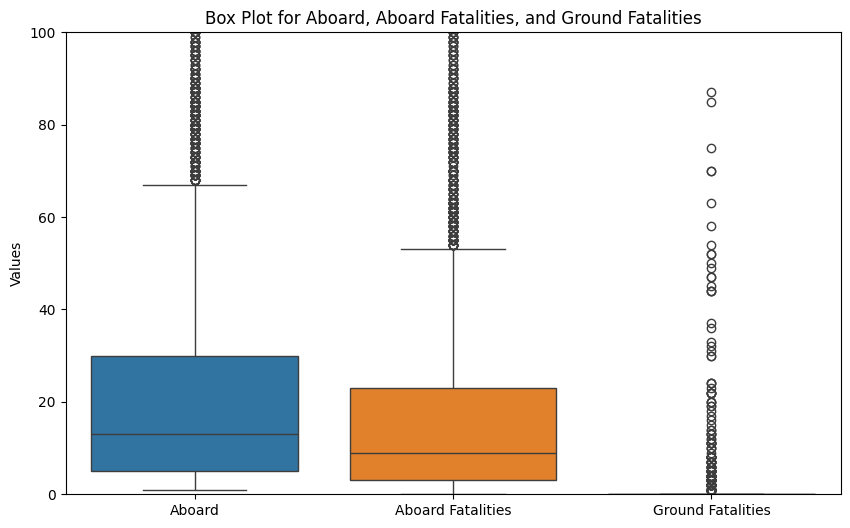

In [151]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['aboard', 'aboard_fatalities', 'ground_fatalities']])
plt.title('Box Plot for Aboard, Aboard Fatalities, and Ground Fatalities')
plt.ylim(0, 100) # there are outliers with large values, so we will limit the graph along the y-axis.
plt.ylabel('Values')
plt.xticks([0, 1, 2], ['Aboard', 'Aboard Fatalities', 'Ground Fatalities'])
plt.show()

In [152]:
print("\nDescription of numerical columns:")
print(df[['aboard', 'aboard_fatalities', 'ground_fatalities']].describe())


Description of numerical columns:
            aboard  aboard_fatalities  ground_fatalities
count  5234.000000        5234.000000        5234.000000
mean     27.599733          20.112533           1.597440
std      43.114499          33.242367          54.045063
min       1.000000           0.000000           0.000000
25%       5.000000           3.000000           0.000000
50%      13.000000           9.000000           0.000000
75%      30.000000          23.000000           0.000000
max     644.000000         583.000000        2750.000000


**Aboard**

*   Mean: 27.60 people on board.
*   Standard Deviation (Std): 43.11, indicating high variability.
*   Minimum (Min): 1 person (likely involving small private planes).
*   Maximum (Max): 644 people, likely related to large airliners.
*   Median (50%): 13 people, which is lower than the mean, indicating right-skewed asymmetry (rare but large disasters).
*   In 25% of cases, there were 5 or fewer people on board.
*   In 75% of cases, there were no more than 30 people on board.

Smaller planes are more common than large airliners.

**Aboard Fatalities**

*   Mean: 20.11 fatalities on board.
*   Standard Deviation (Std): 33.24, indicating high dispersion
*   Minimum (Min): 0 (there are accidents where no one died aboard, that doesn't mean that no one died on the ground).
*   Maximum (Max): 583 fatalities
*   Median (50%): 9 fatalities, which is less than the mean, meaning there are rare accidents with a high number of fatalities.
*   In 25% of cases, 3 or fewer people died.
*   In 75% of cases, 23 or fewer people died.

Most accidents still had a relatively small number of fatalities.

**Ground Fatalities**

*   Mean: 1.60 fatalities on the ground.
*   Standard Deviation (Std): 54.04, a very high value, indicating rare but extremely tragic incidents.
*   Minimum (Min): 0 (in most cases, there were no fatalities on the ground).
*   Maximum (Max): 2750 fatalities (referring to the September 11, 2001 terrorist attack)
*   Median (50%): 0 fatalities, meaning that in half of the cases, disasters did not affect people on the ground.
*   In 75% of cases, there were no fatalities on the ground.

However, the upper quartile (max outliers) shows rare disasters with large numbers of fatalities.

**Conclusion**


*   The data is highly asymmetric, especially for fatalities on board and on the ground (there are rare but extremely tragic incidents).
*   In most disasters, no one died on the ground, but some incidents resulted in a huge number of fatalities.
*   The number of passengers and fatalities on board has a wide range, which is due to the differences between private and commercial planes. Therefore, it is useful to explore the quantitative data separately for each sector: military, private, and commercial
*   The mean values are higher than the median, indicating the impact of rare disasters with mass fatalities.
*   We will remove the largest outlier — the September 11th attack on the Twin Towers, as this event can be considered extraordinary and does not fit into the overall statistics.

In [153]:
df = df[~df['ground_fatalities'].isin([2750])]

In [154]:
print(df[['ground_fatalities']].describe())

       ground_fatalities
count        5232.000000
mean            0.546827
std             5.729160
min             0.000000
25%             0.000000
50%             0.000000
75%             0.000000
max           225.000000


Let's analyze quantitative data for different aviation sectors.

In [155]:
military_df = df[df['flight_category'] == 'military']
private_df = df[df['flight_category'] == 'private & services']
commercial_df = df[df['flight_category'] == 'commercial']

In [156]:
display("\nDescription of numerical columns:")
display(military_df[['aboard', 'aboard_fatalities', 'ground_fatalities']].describe())

'\nDescription of numerical columns:'

,aboard,aboard_fatalities,ground_fatalities
count,773.000000,773.000000,773.000000
mean,27.664942,25.353169,1.366106
std,27.379510,24.304006,7.618442
min,1.000000,0.000000,0.000000
25%,13.000000,12.000000,0.000000
50%,21.000000,20.000000,0.000000
75%,32.000000,30.000000,0.000000
max,330.000000,275.000000,87.000000


In [157]:
outliers_ground_m = military_df[military_df['ground_fatalities'] > 1]  # based on maximum value
outliers_aboard_m = military_df[military_df['aboard_fatalities'] > 60] # based on upper bound
no_fatalities_m = military_df[(military_df['aboard_fatalities'] == 0) & (military_df['aboard'] > 1)]

In [158]:
min_val_m_gf = military_df['ground_fatalities'].min()
q1_m_gf = military_df['ground_fatalities'].quantile(0.25)
median_m_gf = military_df['ground_fatalities'].mean()
q3_m_gf = military_df['ground_fatalities'].quantile(0.75)
max_val_m_gf = military_df['ground_fatalities'].max()

iqr_m_gf = q3_m_gf - q1_m_gf
lower_m_gf = q1_m_gf - 1.5 * iqr_m_gf
upper_m_gf = q3_m_gf + 1.5 * iqr_m_gf

display(f"Minimum value (min): {min_val_m_gf}")
display(f"25th percentile (Q1): {q1_m_gf}")
display(f"Median (50%): {median_m_gf}")
display(f"75th percentile (Q3): {q3_m_gf}")
display(f"Maximum value (max): {max_val_m_gf}")
display(f"IQR: {iqr_m_gf}")
display(f"Lower bound for outliers: {lower_m_gf}")
display(f"Upper bound for outliers: {upper_m_gf}")

'Minimum value (min): 0'

'25th percentile (Q1): 0.0'

'Median (50%): 1.3661060802069858'

'75th percentile (Q3): 0.0'

'Maximum value (max): 87'

'IQR: 0.0'

'Lower bound for outliers: 0.0'

'Upper bound for outliers: 0.0'

In [159]:
min_val_m_af = military_df['aboard_fatalities'].min()
q1_m_af = military_df['aboard_fatalities'].quantile(0.25)
median_m_af = military_df['aboard_fatalities'].mean()
q3_m_af = military_df['aboard_fatalities'].quantile(0.75)
max_val_m_af = military_df['aboard_fatalities'].max()

iqr_m_af = q3_m_af - q1_m_af
lower_m_af = q1_m_af - 1.5 * iqr_m_af
upper_m_af = q3_m_af + 1.5 * iqr_m_af

display(f"Minimum value (min): {min_val_m_af}")
display(f"25th percentile (Q1): {q1_m_af}")
display(f"Median (50%): {median_m_af}")
display(f"75th percentile (Q3): {q3_m_af}")
display(f"Maximum value (max): {max_val_m_af}")
display(f"IQR: {iqr_m_af}")
display(f"Lower bound for outliers: {lower_m_af}")
display(f"Upper bound for outliers: {upper_m_af}")

'Minimum value (min): 0'

'25th percentile (Q1): 12.0'

'Median (50%): 25.353169469598964'

'75th percentile (Q3): 30.0'

'Maximum value (max): 275'

'IQR: 18.0'

'Lower bound for outliers: -15.0'

'Upper bound for outliers: 57.0'

In [160]:
display("\nDescription of numerical columns:")
display(private_df[['aboard', 'aboard_fatalities', 'ground_fatalities']].describe())

'\nDescription of numerical columns:'

,aboard,aboard_fatalities,ground_fatalities
count,2967.000000,2967.000000,2967.000000
mean,7.517695,6.190765,0.347152
std,5.290637,4.907507,5.528826
min,1.000000,0.000000,0.000000
25%,3.000000,2.000000,0.000000
50%,6.000000,4.000000,0.000000
75%,11.000000,9.000000,0.000000
max,20.000000,20.000000,225.000000


In [161]:
outliers_ground_p = private_df[private_df['ground_fatalities'] > 1] # based on maximum value
outliers_aboard_p = private_df[private_df['aboard_fatalities'] > 19.5] # based on upper bound
no_fatalities_p = private_df[(private_df['aboard_fatalities'] == 0) & (private_df['aboard'] > 1)]

In [162]:
min_val_p_gf = private_df['ground_fatalities'].min()
q1_p_gf = private_df['ground_fatalities'].quantile(0.25)
median_p_gf = private_df['ground_fatalities'].mean()
q3_p_gf = private_df['ground_fatalities'].quantile(0.75)
max_val_p_gf = private_df['ground_fatalities'].max()

iqr_p_gf = q3_m_gf - q1_m_gf
lower_p_gf = q1_m_gf - 1.5 * iqr_m_gf
upper_p_gf = q3_m_gf + 1.5 * iqr_m_gf

display(f"Minimum value (min): {min_val_p_gf}")
display(f"25th percentile (Q1): {q1_p_gf}")
display(f"Median (50%): {median_p_gf}")
display(f"75th percentile (Q3): {q3_p_gf}")
display(f"Maximum value (max): {max_val_p_gf}")
display(f"IQR: {iqr_p_gf}")
display(f"Lower bound for outliers: {lower_p_gf}")
display(f"Upper bound for outliers: {upper_p_gf}")

'Minimum value (min): 0'

'25th percentile (Q1): 0.0'

'Median (50%): 0.3471520053926525'

'75th percentile (Q3): 0.0'

'Maximum value (max): 225'

'IQR: 0.0'

'Lower bound for outliers: 0.0'

'Upper bound for outliers: 0.0'

In [163]:
min_val_p_af = private_df['aboard_fatalities'].min()
q1_p_af = private_df['aboard_fatalities'].quantile(0.25)
median_p_af = private_df['aboard_fatalities'].mean()
q3_p_af = private_df['aboard_fatalities'].quantile(0.75)
max_val_p_af = private_df['aboard_fatalities'].max()

iqr_p_af = q3_p_af - q1_p_af
lower_p_af = q1_p_af - 1.5 * iqr_p_af
upper_p_af = q3_p_af + 1.5 * iqr_p_af

display(f"Minimum value (min): {min_val_p_af}")
display(f"25th percentile (Q1): {q1_p_af}")
display(f"Median (50%): {median_p_af}")
display(f"75th percentile (Q3): {q3_p_af}")
display(f"Maximum value (max): {max_val_p_af}")
display(f"IQR: {iqr_p_af}")
display(f"Lower bound for outliers: {lower_p_af}")
display(f"Upper bound for outliers: {upper_p_af}")

'Minimum value (min): 0'

'25th percentile (Q1): 2.0'

'Median (50%): 6.190765082574991'

'75th percentile (Q3): 9.0'

'Maximum value (max): 20'

'IQR: 7.0'

'Lower bound for outliers: -8.5'

'Upper bound for outliers: 19.5'

In [164]:
display("\nDescription of numerical columns:")
display(commercial_df[['aboard', 'aboard_fatalities', 'ground_fatalities']].describe())

'\nDescription of numerical columns:'

,aboard,aboard_fatalities,ground_fatalities
count,1492.000000,1492.000000,1492.000000
mean,67.432976,45.004021,0.519437
std,60.714670,49.999504,4.885574
min,21.000000,0.000000,0.000000
25%,29.000000,17.750000,0.000000
50%,45.000000,30.000000,0.000000
75%,83.000000,55.000000,0.000000
max,644.000000,583.000000,125.000000


In [165]:
outliers_ground_c = commercial_df[commercial_df['ground_fatalities'] > 1] # based on maximum value
outliers_aboard_c = commercial_df[commercial_df['aboard_fatalities'] > 150] # based on upper bound
no_fatalities_c = commercial_df[(commercial_df['aboard_fatalities'] == 0) & (private_df['aboard'] > 1)]

<ipython-input-165-bcc8288ec872>:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [166]:
min_val_c_gf = commercial_df['ground_fatalities'].min()
q1_c_gf = commercial_df['ground_fatalities'].quantile(0.25)
median_c_gf = commercial_df['ground_fatalities'].mean()
q3_c_gf = commercial_df['ground_fatalities'].quantile(0.75)
max_val_c_gf = commercial_df['ground_fatalities'].max()

iqr_c_gf = q3_c_gf - q1_c_gf
lower_c_gf = q1_c_gf - 1.5 * iqr_c_gf
upper_c_gf = q3_c_gf + 1.5 * iqr_c_gf

display(f"Minimum value (min): {min_val_c_gf}")
display(f"25th percentile (Q1): {q1_c_gf}")
display(f"Median (50%): {median_c_gf}")
display(f"75th percentile (Q3): {q3_c_gf}")
display(f"Maximum value (max): {max_val_c_gf}")
display(f"IQR: {iqr_c_gf}")
display(f"Lower bound for outliers: {lower_c_gf}")
display(f"Upper bound for outliers: {upper_c_gf}")

'Minimum value (min): 0'

'25th percentile (Q1): 0.0'

'Median (50%): 0.5194369973190348'

'75th percentile (Q3): 0.0'

'Maximum value (max): 125'

'IQR: 0.0'

'Lower bound for outliers: 0.0'

'Upper bound for outliers: 0.0'

In [167]:
min_val_c_af = commercial_df['aboard_fatalities'].min()
q1_c_af = commercial_df['aboard_fatalities'].quantile(0.25)
median_c_af = commercial_df['aboard_fatalities'].mean()
q3_c_af = commercial_df['aboard_fatalities'].quantile(0.75)
max_val_c_af = commercial_df['aboard_fatalities'].max()

iqr_c_af = q3_c_af - q1_c_af
lower_c_af = q1_c_af - 1.5 * iqr_c_af
upper_c_af = q3_c_af + 1.5 * iqr_c_af

display(f"Minimum value (min): {min_val_c_af}")
display(f"25th percentile (Q1): {q1_c_af}")
display(f"Median (50%): {median_c_af}")
display(f"75th percentile (Q3): {q3_c_af}")
display(f"Maximum value (max): {max_val_c_af}")
display(f"IQR: {iqr_c_af}")
display(f"Lower bound for outliers: {lower_c_af}")
display(f"Upper bound for outliers: {upper_c_af}")

'Minimum value (min): 0'

'25th percentile (Q1): 17.75'

'Median (50%): 45.00402144772118'

'75th percentile (Q3): 55.0'

'Maximum value (max): 583'

'IQR: 37.25'

'Lower bound for outliers: -38.125'

'Upper bound for outliers: 110.875'

In [168]:
outliers = pd.concat([
    outliers_ground_m, outliers_aboard_m, no_fatalities_m,
    outliers_ground_p, outliers_aboard_p, no_fatalities_p,
    outliers_ground_c, outliers_aboard_c, no_fatalities_c
])

In [169]:
df = df[~df.index.isin(outliers.index)] # let's delete outliers

In [170]:
military_df = df[df['flight_category'] == 'military']
private_df = df[df['flight_category'] == 'private & services']
commercial_df = df[df['flight_category'] == 'commercial']

In [171]:
data_loss(df, df_raw, column_name='date') # need to check the data loss after correction

Absolute data loss in column date: 324
Relative data loss in column date: 6.15%


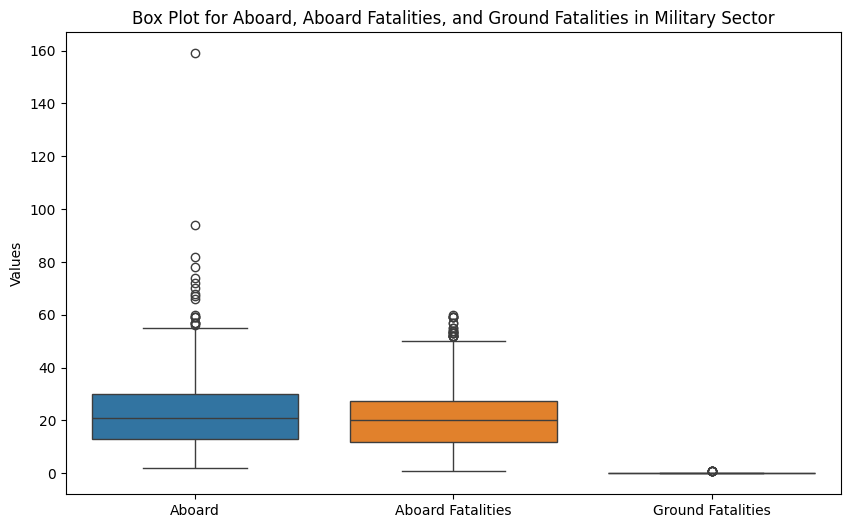

In [172]:
# let's vizualize quantitative data for each sector
plt.figure(figsize=(10, 6))
sns.boxplot(data=military_df[['aboard', 'aboard_fatalities', 'ground_fatalities']])
plt.title('Box Plot for Aboard, Aboard Fatalities, and Ground Fatalities in Military Sector')
plt.ylabel('Values')
plt.xticks([0, 1, 2], ['Aboard', 'Aboard Fatalities', 'Ground Fatalities'])
plt.show()

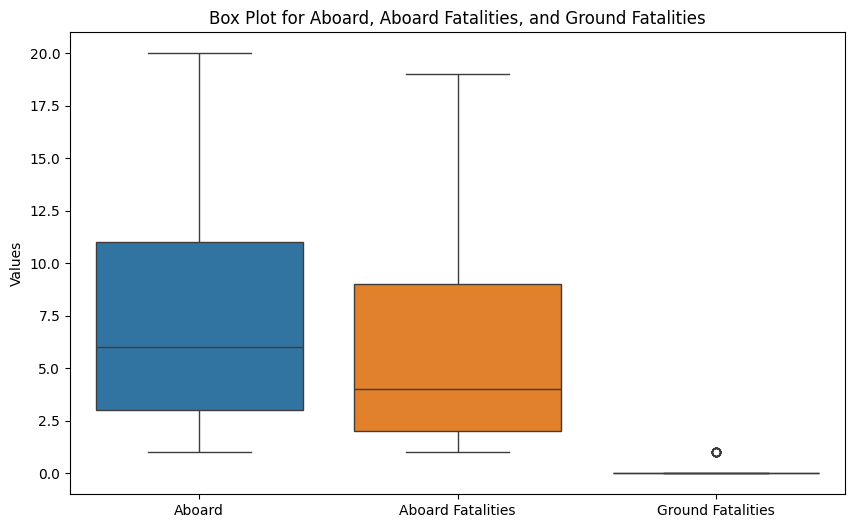

In [173]:
# let's vizualize quantitative data for each sector
plt.figure(figsize=(10, 6))
sns.boxplot(data=private_df[['aboard', 'aboard_fatalities', 'ground_fatalities']])
plt.title('Box Plot for Aboard, Aboard Fatalities, and Ground Fatalities')
plt.ylabel('Values')
plt.xticks([0, 1, 2], ['Aboard', 'Aboard Fatalities', 'Ground Fatalities'])
plt.show()

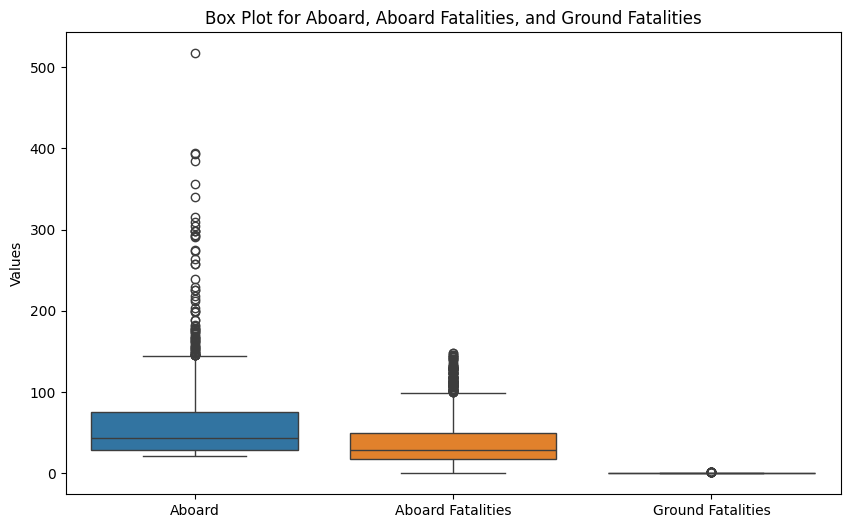

In [174]:
# let's vizualize quantitative data for each sector
plt.figure(figsize=(10, 6))
sns.boxplot(data=commercial_df[['aboard', 'aboard_fatalities', 'ground_fatalities']])
plt.title('Box Plot for Aboard, Aboard Fatalities, and Ground Fatalities')
plt.ylabel('Values')
plt.xticks([0, 1, 2], ['Aboard', 'Aboard Fatalities', 'Ground Fatalities'])
plt.show()

### Summary Column Correction

The Summary column contains a large amount of information in text form, which provides detailed descriptions of the causes and circumstances of the accidents. For a more accurate analysis, it is recommended to extract the main causes from these descriptions and classify them among the most common incident causes, which we have identified as follows:

*   Crashed into an obstacle (mountain, sea, etc.)
*   Crashed during takeoff (or shortly after)
*   Crashed en route
*   Unknow reasons
*   Weather related
*   Crashed while attempting to land
*   Crashed during approach
*   Pilot/Crew error
*   Technical issues
*   Shot down by enemy forces

In [175]:
df_known = df[df["category"] != "Unknown"]
df_unknown = df[(df["category"] == "Unknown") & (df["summary"] != "Unknown")]

In [176]:
X_train, X_test, y_train, y_test = train_test_split(df_known["summary"], df_known["category"], test_size=0.2, random_state=42)

In [177]:
model = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", ngram_range=(1, 2))),
    ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
])

In [178]:
model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('clf', RandomForestClassifier(random_state=42))])

In [179]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

                                                precision    recall  f1-score   support

                       Crashed during approach       0.83      0.15      0.25        34
     Crashed during takeoff (or shortly after)       0.75      0.83      0.79       112
                              Crashed en route       0.84      0.78      0.81        65
Crashed into an obstacle (mountain, sea, etc.)       0.69      0.88      0.77       377
              Crashed while attempting to land       0.77      0.71      0.74        89
                              Pilot/Crew error       1.00      0.50      0.67         2
                     Shot down by enemy forces       0.88      0.85      0.86        26
                               Technical issue       0.69      0.29      0.41        31
                               Weather related       0.79      0.26      0.39        90

                                      accuracy                           0.73       826
                              

In [180]:
df.loc[df_unknown.index, "category"] = model.predict(df_unknown["summary"])

In [181]:
df.loc[df["summary"] == "unknown", "category"] = "Unknow reason"

In [182]:
df["category"].value_counts()

,count
category,
"Crashed into an obstacle (mountain, sea, etc.)",2257
Crashed during takeoff (or shortly after),660
Crashed while attempting to land,463
Weather related,404
Unknow reason,381
Crashed en route,284
Technical issue,200
Crashed during approach,153
Shot down by enemy forces,121


In [183]:
# A sample of 10 randomly selected Summaries and Categories for evaluating the actions taken.
sample_records = df.sample(10)[["summary", "category"]]
for i, row in sample_records.iterrows():
    print(f"Summary: {row['summary']}\nPredicted Category: {row['category']}\n{'-'*50}")

Summary: crashed into trees shortly after taking off. the pilot-in-command diverted attention from operation.  pilot rotated at v2, reduced power, co-pilot raised gear, prop hit runway.
Predicted Category: Crashed into an obstacle (mountain, sea, etc.)
--------------------------------------------------
Summary: crashed shortly after takeoff in a snow storm. failure of the pilot to recognize his proximity to the ground due to heavy snow which entirely covered the terrain.
Predicted Category: Crashed during takeoff (or shortly after)
--------------------------------------------------
Summary: the plane, on a positioning flight crashed into rugged woods during an approach to land. the pilot's continued vfr flight into imc conditions, by failing to maintain altitude, and descending from vfr conditions into imc, which resulted in him subsequently impacting with trees. factors in this accident were: reduced visibility due to dark night and fog. an additional factor was the pilot was not cert

## EDA

Now the data is ready, and we can proceed with the research process by answering the following questions.

### Top Dangerous Operators

Let's identify the most dangerous operator in 3 different categroies - military, private, commercial

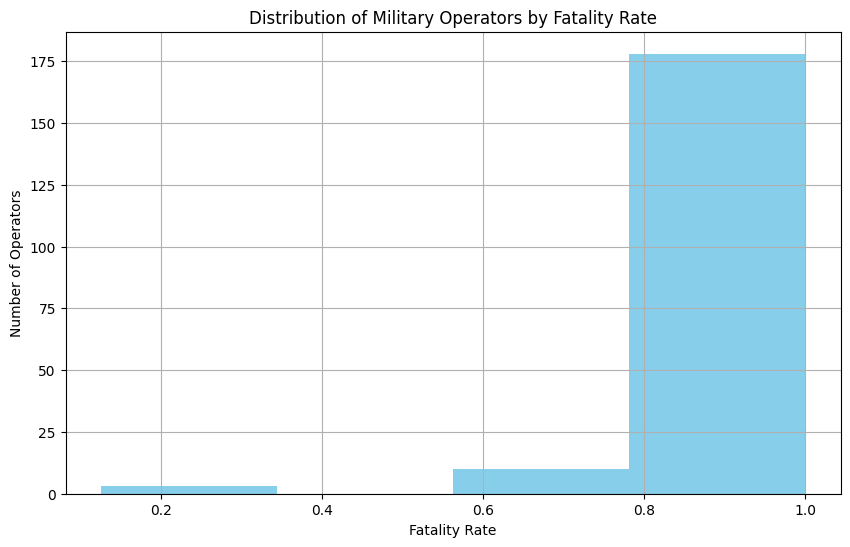

In [184]:
military_fatality_rate = military_df.groupby('operator')['fatality_rate'].mean().sort_values(ascending=False)
military_fatality_rate.plot(kind='hist', bins=4, color='skyblue', figsize=(10, 6))
plt.title('Distribution of Military Operators by Fatality Rate')
plt.xlabel('Fatality Rate')
plt.ylabel('Number of Operators')
plt.grid(True)
plt.show()

In [185]:
operator_stats = military_df.groupby("operator").agg(
    total_crashes=("date", "count"),
    total_fatalities=("aboard_fatalities", "sum"),
    first_crash=("date", "min"),
    last_crash=("date", "max")
).reset_index()

operator_stats["fatalities_per_crash"] = operator_stats["total_fatalities"] / operator_stats["total_crashes"]
dangerous_operators = operator_stats.sort_values(by="fatalities_per_crash", ascending=False)
display(dangerous_operators[["operator", "fatalities_per_crash"]].head(10))

,operator,fatalities_per_crash
171,Military - Unified Yemen Air Force,57.0
7,Eastern Air Lines / Military - Bolivian Air Force,55.0
78,Military - Israel Air Force,54.0
108,Military - Republiof South Korea Air Force,53.0
56,Military - French Navy,52.0
136,Military - Soviet Navy,52.0
10,Hughes Airwest / Military - US Marine Air Corps,50.0
42,Military - Dostum-Galboddin Militia,50.0
190,United Air Lines / Military - U.S. Air Force,49.0
25,Military - British Air Ministry,48.0


In [186]:
operator_stats["years_active"] = (operator_stats["last_crash"] - operator_stats["first_crash"]).dt.days / 365.25
operator_stats["years_active"] = operator_stats["years_active"].replace(0, 1)
operator_stats["crashes_per_year"] = operator_stats["total_crashes"] / operator_stats["years_active"]
operator_stats = operator_stats[operator_stats["total_crashes"] > 1]
dangerous_operators = operator_stats.sort_values(by="crashes_per_year", ascending=False)
display(dangerous_operators[["operator", "crashes_per_year"]].head(10))

,operator,crashes_per_year
32,Military - Chilian Air Force,26.089286
21,Military - Azerbaijan Air Force,8.301136
159,Military - U.S. Army Air Forces,8.148355
61,Military - Georgian Air Force,8.116667
108,Military - Republiof South Korea Air Force,6.352174
63,Military - German Army,5.003425
174,Military - United States Army Air Force,3.366359
64,Military - German Navy,3.048831
148,Military - U.S. Air Force,2.514267
74,Military - Iranian Air Force,2.484694


In [187]:
fig = px.scatter(
    operator_stats,
    x="crashes_per_year",
    y="fatalities_per_crash",
    hover_name="operator",
    title="Most dangerous operators in Military Sector",
    labels={"crashes_per_year": "Crashes per Year", "fatalities_per_crash": "Fatalities per Crash"},
    size_max=10
)

fig.update_traces(marker=dict(size=8, opacity=0.7))
fig.update_layout(
    width=900, height=600,
    xaxis=dict(title="Crashes per Year"),
    yaxis=dict(title="Fatalities per Crash"),
    template="plotly_white"
)

fig.show()

Analyzing this chart, it can be divided into 4 parts:



*   Top left corner (deadly but less frequent). These are airlines that rarely have accidents, but when they do, they result in a high number of fatalities.
*   Top right corner (frequent and very deadly). The most dangerous category! Airlines where accidents happen frequently and with a high number of fatalities. We have no representatives in this category.
*   Bottom left corner (infrequent and less deadly). These are airlines with rare accidents and a small number of casualties.
*   Bottom right corner (frequent but less deadly). Accidents happen frequently, but with a relatively lower number of fatalities.

Let’s focus on the top representatives in the top left square — deadly but less frequent. This means that if you get into an accident, there is a higher probability of dying. And in the bottom right corner—frequent but less deadly. This means that choosing this airline, you might be involved in accidents, but the chances of dying are lower:

*   Military - Chilian Air Force
*   Military - Republiof South Korea Air Force
*   Military - Azerbaijan Air Force
*   Military - Georgian Air Force
*   Military - Ethiopian air force

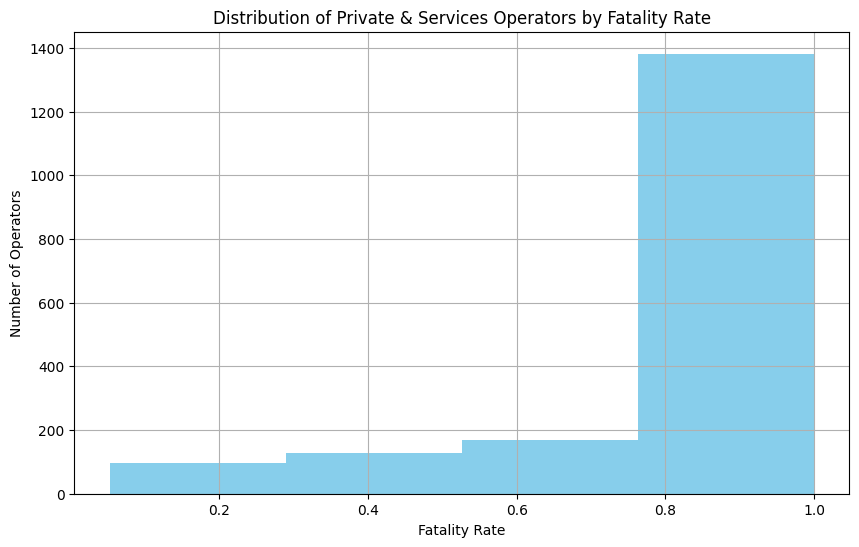

In [188]:
private_fatality_rate = private_df.groupby('operator')['fatality_rate'].mean().sort_values(ascending=False)
private_fatality_rate.plot(kind='hist', bins=4, color='skyblue', figsize=(10, 6))
plt.title('Distribution of Private & Services Operators by Fatality Rate')
plt.xlabel('Fatality Rate')
plt.ylabel('Number of Operators')
plt.grid(True)
plt.show()

In [189]:
operator_stats = private_df.groupby("operator").agg(
    total_crashes=("date", "count"),
    total_fatalities=("aboard_fatalities", "sum"),
    first_crash=("date", "min"),
    last_crash=("date", "max")
).reset_index()

operator_stats["fatalities_per_crash"] = operator_stats["total_fatalities"] / operator_stats["total_crashes"]
dangerous_operators = operator_stats.sort_values(by="fatalities_per_crash", ascending=False)
display(dangerous_operators[["operator", "fatalities_per_crash"]].head(10))

,operator,fatalities_per_crash
485,British Commonwealth PacifiAirlines,19.0
1539,TAC Colombia,19.0
734,Executive Airlines,19.0
896,Indian National Airlines,19.0
1656,U. S. Air Force,19.0
465,Blue Wing Airlines,19.0
39,Aero Ferinco Charter,19.0
1579,Team Air,19.0
134,Air Caraibes,19.0
1634,Transportes Aereos Nacionales,19.0


In [190]:
operator_stats["years_active"] = (operator_stats["last_crash"] - operator_stats["first_crash"]).dt.days / 365.25
operator_stats["years_active"] = operator_stats["years_active"].replace(0, 1)
operator_stats["crashes_per_year"] = operator_stats["total_crashes"] / operator_stats["years_active"]
operator_stats = operator_stats[operator_stats["total_crashes"] > 1]
dangerous_operators = operator_stats.sort_values(by="crashes_per_year", ascending=False)
display(dangerous_operators[["operator", "crashes_per_year"]].head(10))

,operator,crashes_per_year
70,Aerolift,42.970588
748,Federal Express,17.817073
1714,VoteTaxi Aéreo,16.602273
129,Air Atlas,13.044643
601,Commercial Air Taxi,12.674290
1324,Rapid Air Transport,9.611842
141,Air Charter,8.494186
1306,Provincetown - Boston Airlines,8.116667
1257,Philippine Aerotransport,8.056985
928,Jamair,6.581081


In [191]:
fig = px.scatter(
    operator_stats,
    x="crashes_per_year",
    y="fatalities_per_crash",
    hover_name="operator",
    title="Most dangerous operators in Private Sector",
    labels={"crashes_per_year": "Crashes per Year", "fatalities_per_crash": "Fatalities per Crash"},
    size_max=10
)

fig.update_traces(marker=dict(size=8, opacity=0.7))
fig.update_layout(
    width=900, height=600,
    xaxis=dict(title="Crashes per Year"),
    yaxis=dict(title="Fatalities per Crash"),
    template="plotly_white"
)

fig.show()

Let’s again focus on the top representatives in the top left square — deadly but less and in the bottom right corner—frequent but less deadly.



*   Aerolift
*   Airfast Service
*   Air India
*   Airlink
*   TAME
*   TAE SA

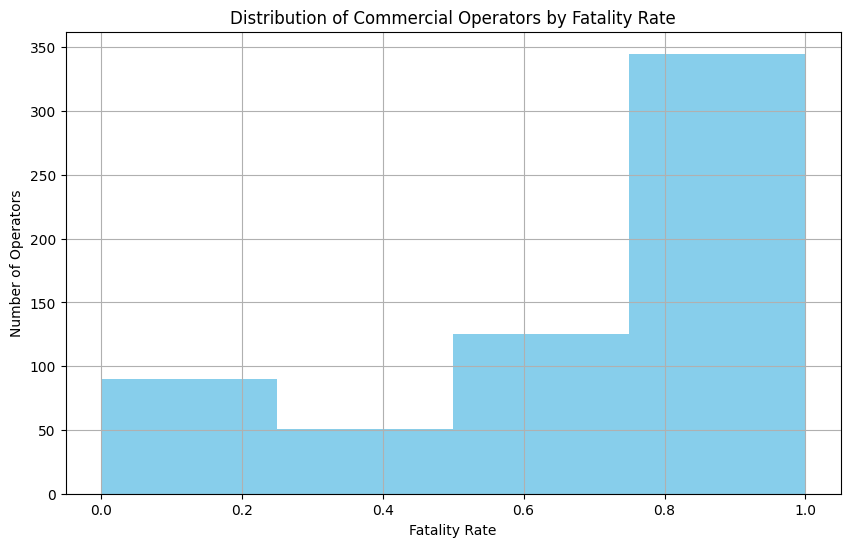

In [192]:
commercial_fatality_rate = commercial_df.groupby('operator')['fatality_rate'].mean().sort_values(ascending=False)
commercial_fatality_rate.plot(kind='hist', bins=4, color='skyblue', figsize=(10, 6))
plt.title('Distribution of Commercial Operators by Fatality Rate')
plt.xlabel('Fatality Rate')
plt.ylabel('Number of Operators')
plt.grid(True)
plt.show()

In [193]:
commercial_df = commercial_df[commercial_df['operator'] != 'Transair Georgia Airlines'] # there are a lot of crashes for one operator in a single year, which is definitely an outlier. Let's remove this.
operator_stats = commercial_df.groupby("operator").agg(
    total_crashes=("date", "count"),
    total_fatalities=("aboard_fatalities", "sum"),
    first_crash=("date", "min"),
    last_crash=("date", "max")
).reset_index()

operator_stats["fatalities_per_crash"] = operator_stats["total_fatalities"] / operator_stats["total_crashes"]
dangerous_operators = operator_stats.sort_values(by="fatalities_per_crash", ascending=False)
display(dangerous_operators[["operator", "fatalities_per_crash"]].head(10))

,operator,fatalities_per_crash
235,Flash Air,148.0
595,Vladivostokavia,145.0
271,Independent Air Inc.,144.0
113,Aviation Development Corporation,143.0
596,Vnokovo Airlines,141.0
576,Union des Transports Aeriens de Guinee,140.0
67,Air Philippines,131.0
520,TAP (Air Portugal),131.0
571,Ukrainian Cargo Airlines - Congolese Army Cha...,129.0
182,China Southwest Airlines / Xiamen Airlines,128.0


In [194]:
operator_stats["years_active"] = (operator_stats["last_crash"] - operator_stats["first_crash"]).dt.days / 365.25
operator_stats["years_active"] = operator_stats["years_active"].replace(0, 1)
operator_stats["crashes_per_year"] = operator_stats["total_crashes"] / operator_stats["years_active"]
operator_stats = operator_stats[operator_stats["total_crashes"] > 1]
dangerous_operators = operator_stats.sort_values(by="crashes_per_year", ascending=False)
display(dangerous_operators[["operator", "crashes_per_year"]].head(10))

,operator,crashes_per_year
462,Scottish Airlines,10.145833
331,Los Angeles Airways,8.696429
528,Taxader Airlines,6.957143
68,Air Rhodesia,4.509259
212,Devlet Hava Yollari,3.844737
240,Flying Tiger Line,3.804688
38,Aeropesca Colombia,3.462085
65,Air Nautic,2.853516
266,Hunting Air Travel,2.572183
589,ValuJet,2.161243


In [195]:
fig = px.scatter(
    operator_stats,
    x="crashes_per_year",
    y="fatalities_per_crash",
    hover_name="operator",
    title="Most dangerous operators in Commercial Sector",
    labels={"crashes_per_year": "Crashes per Year", "fatalities_per_crash": "Fatalities per Crash"},
    size_max=10
)

fig.update_traces(marker=dict(size=8, opacity=0.7))
fig.update_layout(
    width=900, height=600,
    xaxis=dict(title="Crashes per Year"),
    yaxis=dict(title="Fatalities per Crash"),
    template="plotly_white"
)

fig.show()

Fot the last time let's apply here the same logic - top left square and bottom right:

*   Scottich Airlines
*   Los Angeles Airways
*   Taxader Airlines
*   Flying Tiger Line
*   Gulf Air
*   Iraqi Airways
*   Dan Air Services

When analyzing the danger levels across different sectors of aviation, the commercial sector stands out as the least dangerous. This is supported by the fact that almost half of the operators in this segment have a fatality rate of less than 1. This indicates that fatal incidents occur less frequently in the commercial aviation sector, reflecting high safety standards and strict regulations followed by commercial airlines. In contrast, the military and private sectors show much more alarming statistics: nearly all accidents from operators in these sectors end in tragedies where the entire crew perishes. This can be attributed to the fact that military operators often carry out more risky missions in complex and hazardous conditions, as well as potential resource limitations for maintaining safety standards.

The following operators are considered the most dangerous in their respective sectors:

Private Sector:

*   Aerolift
*   Airfast Service
*   Air India
*   Airlink
*   TAME
*   TAE SA

Military Sector:

*   Chilean Air Force
*   Republic of South Korea Air Force
*   Azerbaijan Air Force
*   Georgian Air Force
*   Ethiopian Air Force

Commercial Sector:

*   Scottish Airlines
*   Los Angeles Airways
*   Taxader Airlines
*   Flying Tiger Line
*   Gulf Air
*   Iraqi Airways
*   Dan Air Services

### Top Common and Dangerous Causes

Let's identify the most common crash causes in different sectors and answer the question: Is the most frequent crash cause also the most dangerous one? If not, which one is the most dangerous?

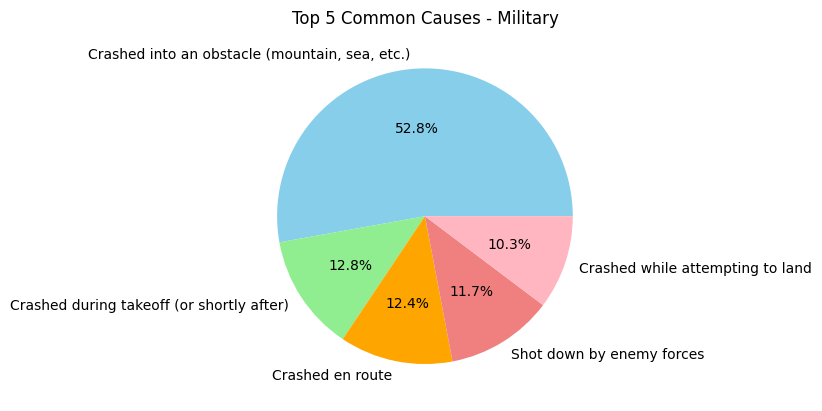

In [196]:
filtered_df = military_df[military_df['category'] != 'Unknown']
top_causes = filtered_df['category'].value_counts().head(5)
top_causes.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'orange', 'lightcoral', 'lightpink'])
plt.title('Top 5 Common Causes - Military')
plt.ylabel('')
plt.show()

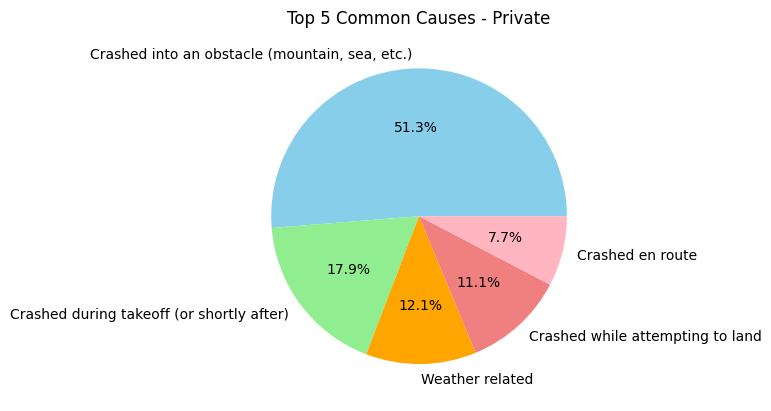

In [197]:
filtered_df = private_df[private_df['category'] != 'Unknown']
top_causes = filtered_df['category'].value_counts().head(5)
top_causes.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'orange', 'lightcoral', 'lightpink'])
plt.title('Top 5 Common Causes - Private')
plt.ylabel('')
plt.show()

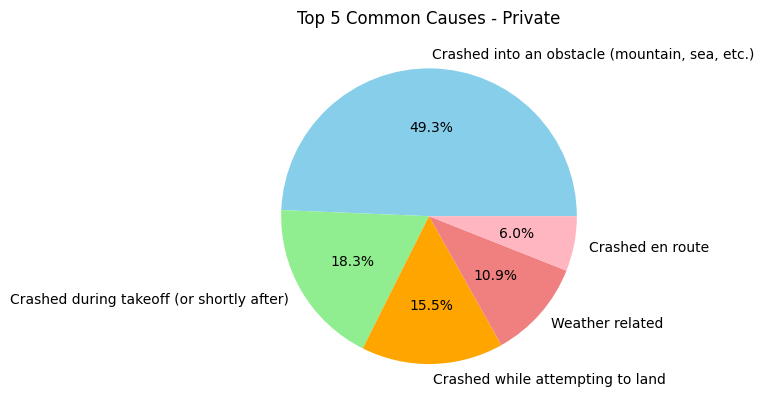

In [198]:
filtered_df = commercial_df[commercial_df['category'] != 'Unknown']
top_causes = filtered_df['category'].value_counts().head(5)
top_causes.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'orange', 'lightcoral', 'lightpink'])
plt.title('Top 5 Common Causes - Private')
plt.ylabel('')
plt.show()

Most common are:

1.   Crashed into an obstacle
2.   Crashed during takeoff

Then for military sector: Shot down by rebel or enemy forces

For private sector: Weather Related

For commercial sector: Crashed while attempting to land

In the military sector, crashes due to external threats, such as being shot down by rebel or enemy forces, are unique, highlighting the dangerous environments in which military aircraft operate. On the other hand, the private sector focuses on more operational issues, such as crashes due to obstacles or weather-related events during en-route flight, suggesting a higher vulnerability during less controlled circumstances.

The commercial sector, however, appears to be most affected by issues during takeoff and approach phases, which points to the critical nature of these stages in commercial aviation. Crashes during these phases may be attributed to factors such as technical failure, human error, or environmental conditions.

In all sectors, crashes caused by obstacles during takeoff and flight phases seem to be common, indicating the ongoing importance of ground safety measures, thorough pre-flight checks, and proper training in handling unexpected challenges during flight. Addressing weather-related issues and improving air traffic management can also contribute significantly to reducing risks, particularly in private and commercial aviation sectors.

To answer the question: Is the most frequent crash cause also the most dangerous one? If not, which one is the most dangerous? Let's again use the Fatal Rate parameter.

In [199]:
filtered_df = military_df[military_df['category'] != 'Unknown']
military_causes_fatality_rate = filtered_df.groupby('category')['fatality_rate'].mean().sort_values(ascending=False).head(5)
military_causes_fatality_rate

,fatality_rate
category,
Pilot/Crew error,0.976744
Technical issue,0.973710
Shot down by enemy forces,0.972961
Crashed en route,0.972474
"Crashed into an obstacle (mountain, sea, etc.)",0.954997


In [200]:
filtered_df = private_df[private_df['category'] != 'Unknown']
private_causes_fatality_rate = filtered_df.groupby('category')['fatality_rate'].mean().sort_values(ascending=False).head(5)
private_causes_fatality_rate

,fatality_rate
category,
Crashed en route,0.926513
Weather related,0.889364
"Crashed into an obstacle (mountain, sea, etc.)",0.872386
Crashed during approach,0.863829
Technical issue,0.859004


In [201]:
filtered_df = commercial_df[commercial_df['category'] != 'Unknown']
commercial_causes_fatality_rate = filtered_df.groupby('category')['fatality_rate'].mean().sort_values(ascending=False).head(5)
private_causes_fatality_rate

,fatality_rate
category,
Crashed en route,0.926513
Weather related,0.889364
"Crashed into an obstacle (mountain, sea, etc.)",0.872386
Crashed during approach,0.863829
Technical issue,0.859004


In many cases, the most frequent crash causes can indeed be considered among the most dangerous ones, especially when we factor in the Fatal Rate. Even though some of these causes might seem less catastrophic at first glance, they can still result in deadly outcomes due to the nature of the incidents and the critical phases of flight in which they occur. Therefore, it is important to consider both the frequency and the fatality rate when assessing the risk of a crash cause, and in many cases, the most common causes also represent significant threats to aviation safety

### Prediction of Crash Cause

Which variable (day / night, season of the year …)  is the most important for prediction crash cause? Let's focus on day/night periods and season of the year.  For the purpose of finding any connection between two categorical scales, we can use the Chi-squared test. First, we will create a pivot table, where in the first case, the rows will represent day or night, and in the second case, the season of the year. The columns will represent the most frequent crash causes. The values in the table will be the number of accidents characteristic for each attribute.

In [202]:
df_unknow = df[df['category'] != 'Unknow reason']
top_5_causes = df_unknow['category'].value_counts().head(5).index
df_filtered = df_unknow[df_unknow['category'].isin(top_5_causes)]
pivot_day_night = pd.pivot_table(df_filtered, index='time_of_day',
                                 columns='category', aggfunc='size', fill_value=0)
pivot_day_night

category,Crashed during takeoff (or shortly after),Crashed en route,"Crashed into an obstacle (mountain, sea, etc.)",Crashed while attempting to land,Weather related
time_of_day,,,,,
Day,275,109,833,159,159
Night,385,175,1424,304,245


In [203]:
chi2, p_value, _, _ = chi2_contingency(pivot_day_night)
print(f'Chi-squared: {chi2}, P-value: {p_value}')

Chi-squared: 7.772243652526272, P-value: 0.10028662729253296


The p-value > 0.05, there is no dependency, and the variable doesnt have a significant impact on the causes of accidents.

In [204]:
df_unknow = df[df['category'] != 'Unknow reason']
top_5_causes = df_unknow['category'].value_counts().head(5).index
df_filtered = df_unknow[df_unknow['category'].isin(top_5_causes)]
pivot_season = pd.pivot_table(df_filtered, index='season',
                                 columns='category', aggfunc='size', fill_value=0)
pivot_season

category,Crashed during takeoff (or shortly after),Crashed en route,"Crashed into an obstacle (mountain, sea, etc.)",Crashed while attempting to land,Weather related
season,,,,,
Fall,169,66,586,118,103
Spring,156,68,501,106,90
Summer,162,66,578,113,71
Winter,173,84,592,126,140


In [205]:
chi2, p_value, _, _ = chi2_contingency(pivot_season)
print(f'Chi-squared: {chi2}, P-value: {p_value}')

Chi-squared: 20.43903408400898, P-value: 0.05922349986180783


The p-value > 0.05, there is no dependency, and the variable does not have a significant impact on the causes of accidents.

### Time-Related Patterns

Let's focus on Time-Related Patterns in 3 sectors of aviasion

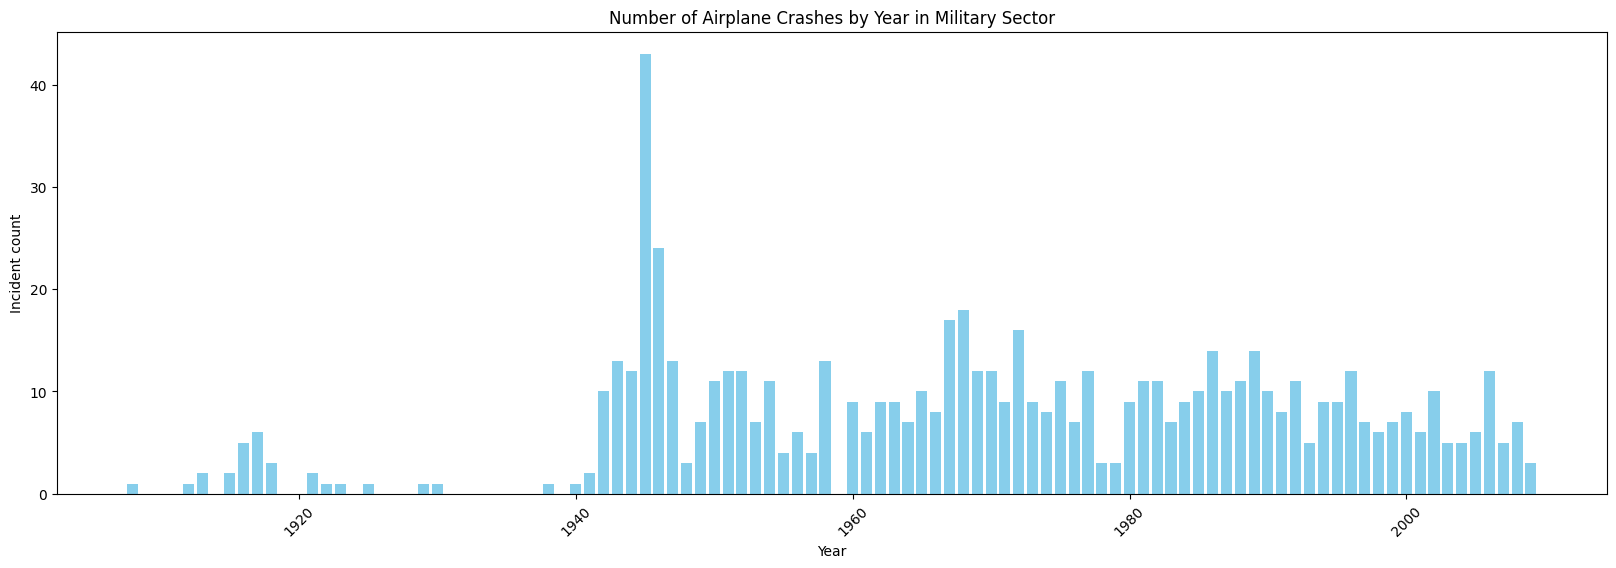

In [206]:
military_year_counts = military_df.groupby("year").size().reset_index(name="incident_count")
plt.figure(figsize=(20, 6))
plt.bar(military_year_counts["year"], military_year_counts["incident_count"], color="skyblue")
plt.xlabel("Year")
plt.ylabel("Incident count")
plt.title("Number of Airplane Crashes by Year in Military Sector")
plt.xticks(rotation=45)
plt.show()

On the graph, we observe two distinct peaks—around 1945 and 1975. These years correspond to some of the largest military conflicts of the 20th century: World War II and the Vietnam War. This may explain the increase in aviation accidents in the military sector.

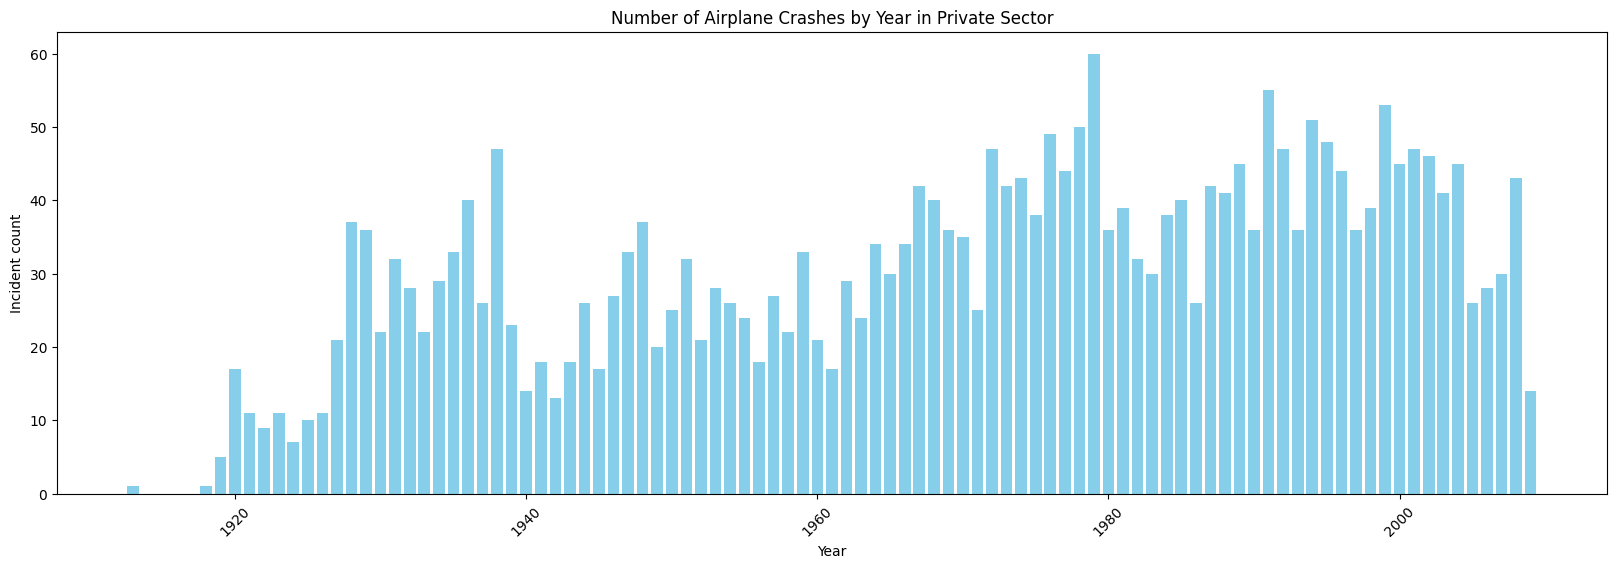

In [207]:
private_year_counts = private_df.groupby("year").size().reset_index(name="incident_count")
plt.figure(figsize=(20, 6))
plt.bar(private_year_counts["year"], private_year_counts["incident_count"], color="skyblue")
plt.xlabel("Year")
plt.ylabel("Incident count")
plt.title("Number of Airplane Crashes by Year in Private Sector")
plt.xticks(rotation=45)
plt.show()

Increase in incidents over time – Until the mid-20th century, the number of airplane crashes was rising. This could be due to the growing number of flights, the development of aviation, and imperfect technology.

Peaks in certain periods – There are noticeable spikes in accidents during the 1940s and 1970s. This may be related to military conflicts (such as World War II and the Vietnam War) or the rapid expansion of civil aviation.

Decrease in crashes in recent years – Since the 2000s, there is a visible trend of declining incidents, likely due to advancements in technology, improved safety standards, and stricter regulations in aviation.

Instability in different periods – After some peak years, there are periods of decline in accident rates, which could be influenced by economic crises, changes in the aviation industry, or regulatory measures.

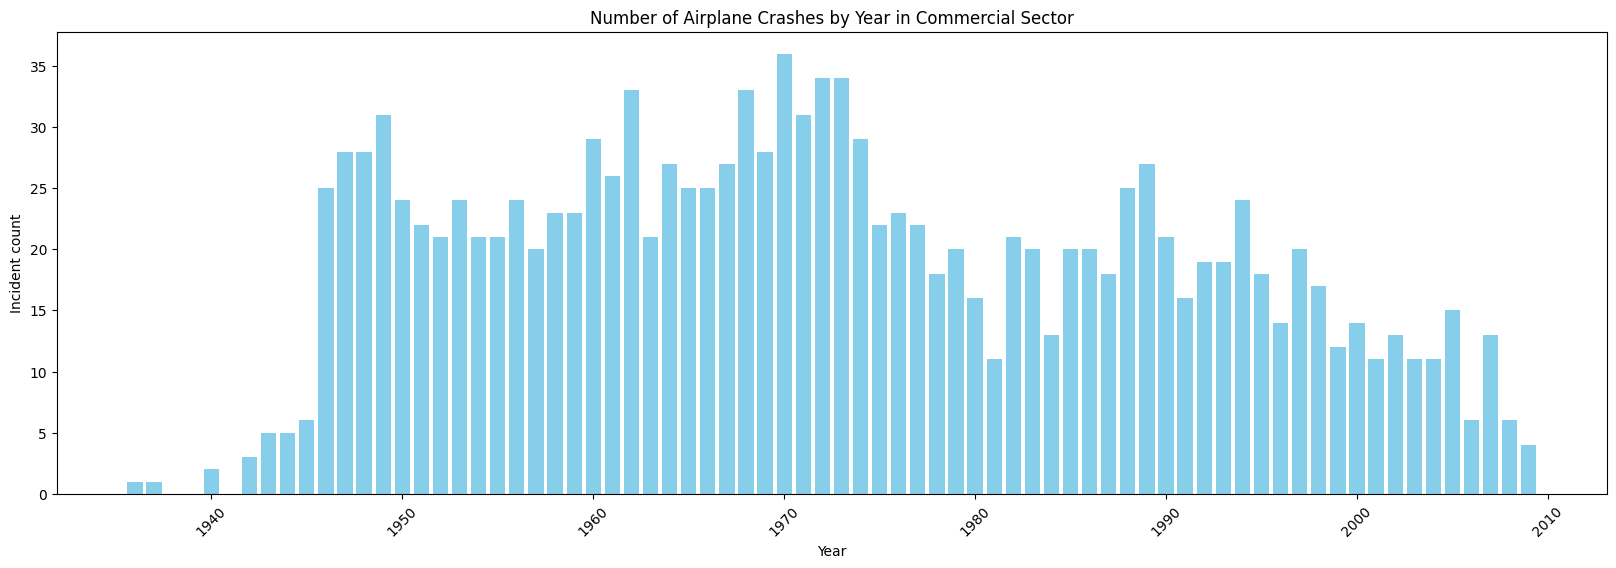

In [208]:
commercial_year_counts = commercial_df.groupby("year").size().reset_index(name="incident_count")
plt.figure(figsize=(20, 6))
plt.bar(commercial_year_counts["year"], commercial_year_counts["incident_count"], color="skyblue")
plt.xlabel("Year")
plt.ylabel("Incident count")
plt.title("Number of Airplane Crashes by Year in Commercial Sector")
plt.xticks(rotation=45)
plt.show()

*   There is a noticeable increase in incidents from the 1940s, peaking around the 1970s. The highest number of crashes appears to occur in the late 1960s to early 1980s. It likely correlates with the growth of commercial aviation.
*   A downward trend starts after the 1980s, with the number of crashes decreasing steadily until 2010. The decline after the 1980s may be attributed to improvements in aviation safety regulations, technology, and stricter operational standards.
*   After 2000, the number of airplane crashes dropped significantly. One of the key reasons was the tightening of security measures following the **2001 tragedy (the September 11 attacks)**, which led to major changes in the aviation industry. New safety standards were introduced, airport security was reinforced, and stricter cockpit access and piloting procedures were implemented. These factors, along with technological advancements, contributed to a significant reduction in commercial aviation accidents.

### Geographical and Regional Factors

Let's focus on Geographical and Regional Factors.

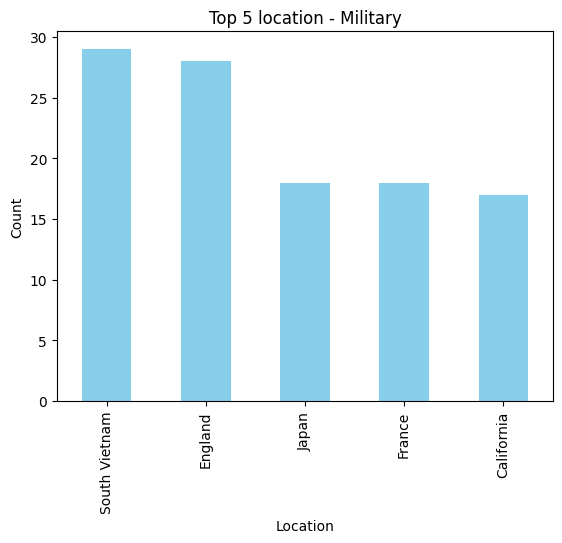

In [209]:
top_location_military = military_df['generalized_crash_location'].value_counts().head(5)
top_location_military.plot(kind='bar', color='skyblue')
plt.title('Top 5 location - Military')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

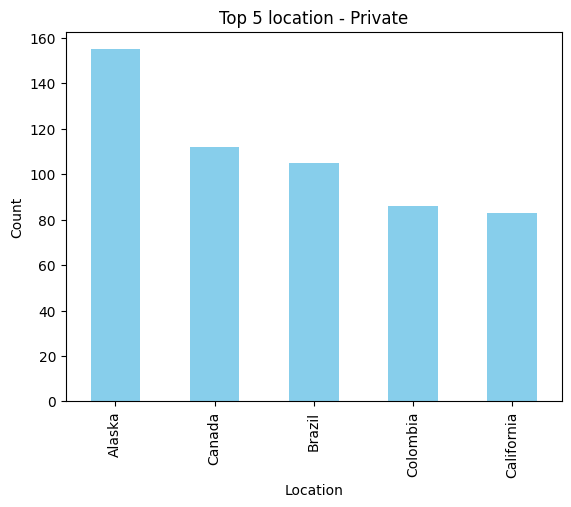

In [210]:
top_location_private = private_df['generalized_crash_location'].value_counts().head(5)
top_location_private.plot(kind='bar', color='skyblue')
plt.title('Top 5 location - Private')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

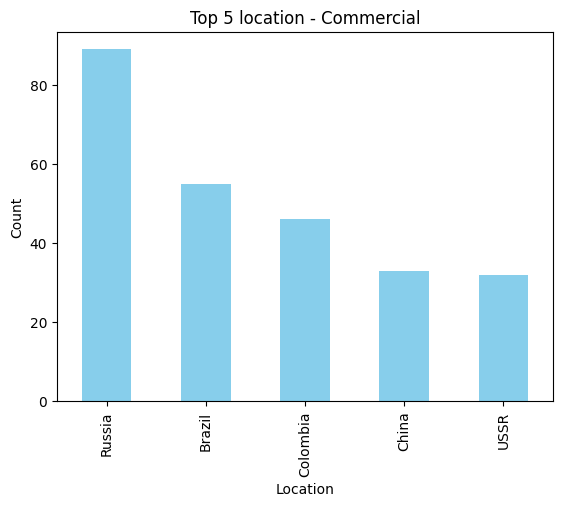

In [211]:
top_location_commercial = commercial_df['generalized_crash_location'].value_counts().head(5)
top_location_commercial.plot(kind='bar', color='skyblue')
plt.title('Top 5 location - Commercial')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

In [212]:
filtered_df = military_df[military_df['generalized_crash_location'] == 'South Vietnam']
top_causes_military_sv = filtered_df['category'].value_counts().head(10)
top_causes_military_sv

,count
category,
"Crashed into an obstacle (mountain, sea, etc.)",7
Crashed during takeoff (or shortly after),6
Shot down by enemy forces,4
Crashed during approach,4
Unknown,3
Crashed en route,2
Technical issue,1
Crashed while attempting to land,1
Weather related,1


In [213]:
filtered_df = private_df[private_df['generalized_crash_location'] == 'Alaska']
top_causes_private_al = filtered_df['category'].value_counts().head(10)
top_causes_private_al

,count
category,
"Crashed into an obstacle (mountain, sea, etc.)",62
Weather related,26
Unknown,23
Crashed en route,16
Crashed during takeoff (or shortly after),15
Technical issue,6
Crashed during approach,4
Crashed while attempting to land,2
Pilot/Crew error,1


In [214]:
filtered_df = commercial_df[commercial_df['generalized_crash_location'] == 'Russia']
top_causes_commercial_rus = filtered_df['category'].value_counts().head(10)
top_causes_commercial_rus

,count
category,
"Crashed into an obstacle (mountain, sea, etc.)",18
Crashed while attempting to land,18
Crashed during takeoff (or shortly after),17
Unknown,13
Weather related,11
Technical issue,5
Crashed en route,4
Crashed during approach,2
Pilot/Crew error,1


*   Military aviation accidents are concentrated in regions with active combat operations or challenging terrain and weather conditions. In South Vietnam, most crashes were caused by enemy fire, collisions with mountains in poor weather, and technical failures.
*   Private aviation accidents often occur in remote and geographically challenging areas such as Alaska and Canada. The main causes are pilot errors, including navigation mistakes, ignoring weather conditions, failure to follow checklists, and equipment malfunctions.
*   Commercial aviation accidents are more frequent in countries with developing infrastructure (Russia, Brazil, Colombia), which may be linked to an aging fleet, insufficient maintenance control, and crew errors. The primary causes include takeoff and landing accidents, pilot mistakes, and technical failures.

### Aircraft and Airport Conditions

Let's focus then on Aircraft and The Airport and The Runway Condition

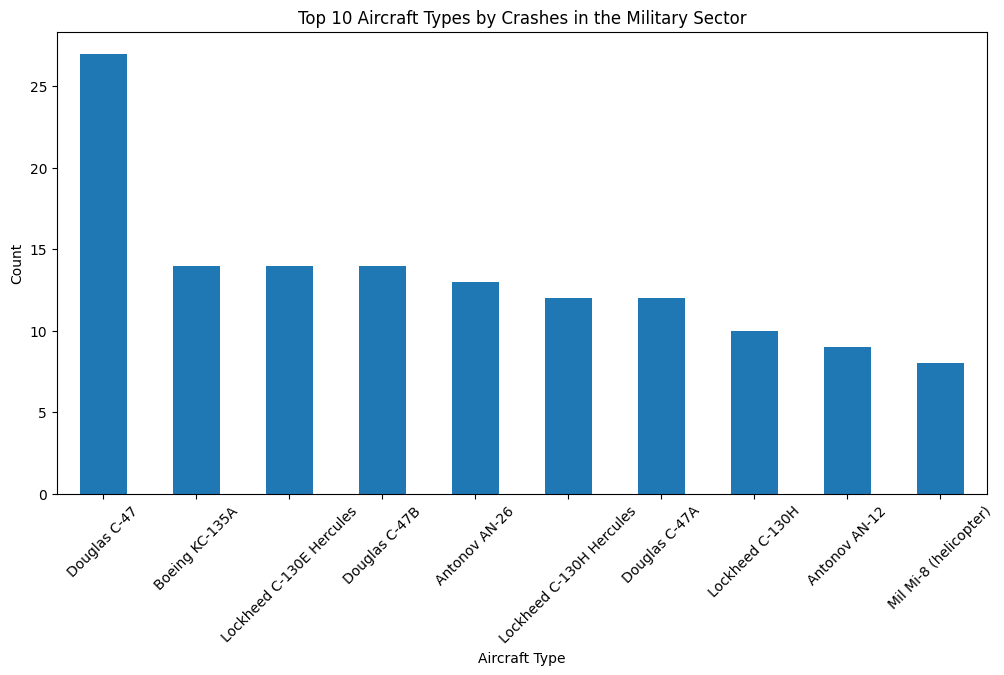

In [215]:
aircraft_accidents_military = military_df['aircraft_type'].value_counts()
plt.figure(figsize=(12, 6))
aircraft_accidents_military[:10].plot(kind='bar')
plt.xlabel('Aircraft Type')
plt.ylabel('Count')
plt.title('Top 10 Aircraft Types by Crashes in the Military Sector')
plt.xticks(rotation=45)
plt.show()

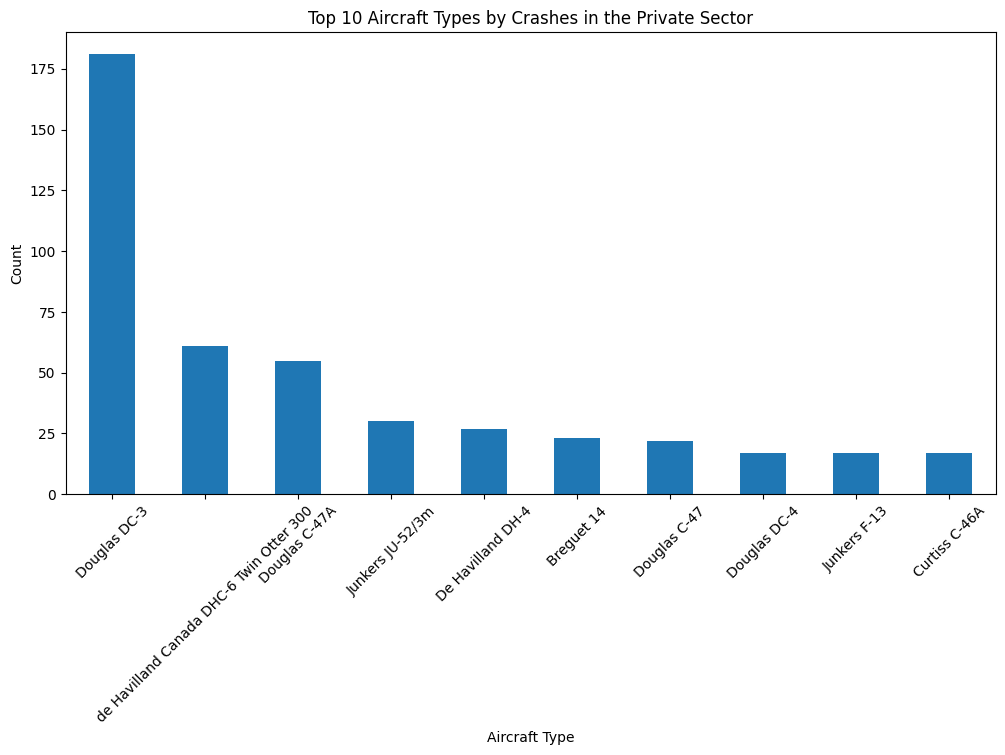

In [216]:
aircraft_accidents_private = private_df['aircraft_type'].value_counts()
plt.figure(figsize=(12, 6))
aircraft_accidents_private[:10].plot(kind='bar')
plt.xlabel('Aircraft Type')
plt.ylabel('Count')
plt.title('Top 10 Aircraft Types by Crashes in the Private Sector')
plt.xticks(rotation=45)
plt.show()

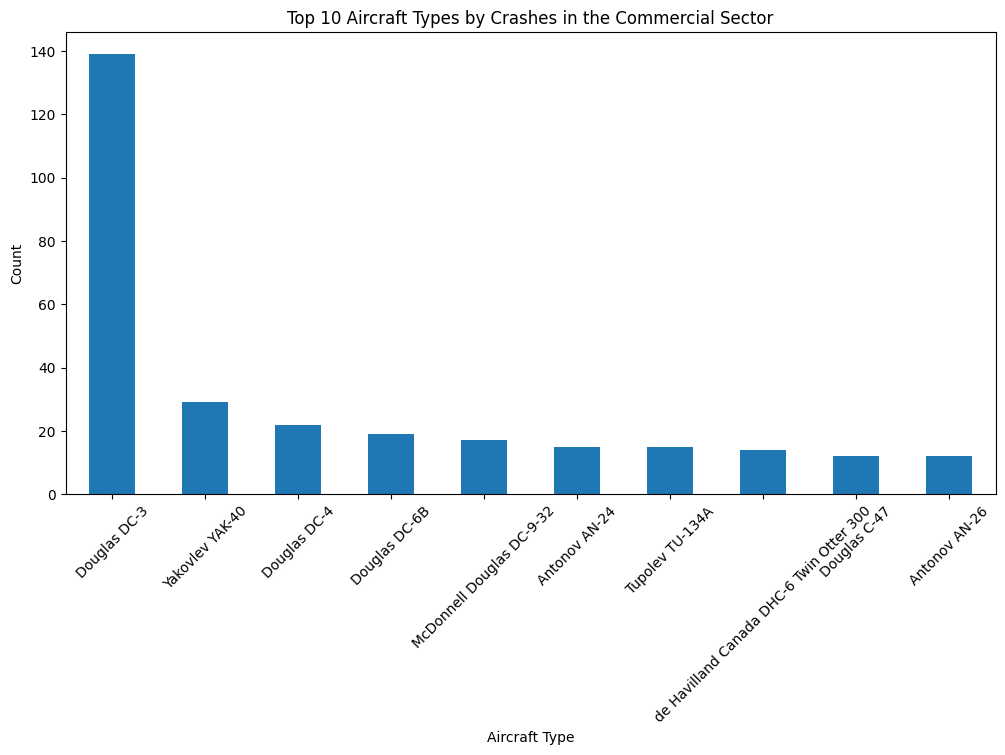

In [217]:
aircraft_accidents_commercial = commercial_df['aircraft_type'].value_counts()
plt.figure(figsize=(12, 6))
aircraft_accidents_commercial[:10].plot(kind='bar')
plt.xlabel('Aircraft Type')
plt.ylabel('Count')
plt.title('Top 10 Aircraft Types by Crashes in the Commercial Sector')
plt.xticks(rotation=45)
plt.show()

In [218]:
filtered_df = df[df['aircraft_type'] == 'Douglas DC-3']
top_causes_douglas = filtered_df['category'].value_counts().head(10)
top_causes_douglas

,count
category,
"Crashed into an obstacle (mountain, sea, etc.)",159
Crashed during takeoff (or shortly after),51
Crashed while attempting to land,27
Weather related,21
Crashed en route,20
Unknow reason,14
Technical issue,10
Crashed during approach,9
Shot down by enemy forces,7


The Douglas DC-3 appears frequently in crash statistics across military, private, and commercial aviation, indicating its widespread use and long operational history. The main causes of DC-3 accidents include takeoff failures, en route crashes, collisions with obstacles (mountains, sea), and landing difficulties. Additionally, given the aircraft's age, it's crucial to carefully monitor its technical condition, conduct regular maintenance, and assess the structural integrity of aging components to reduce accident risks.

## Conclusion

The analysis of aviation crash data reveals that the commercial aviation sector is generally the safest, with a lower fatality rate compared to the private and military sectors. Commercial airlines benefit from strict regulations and high safety standards, resulting in fewer fatal incidents. In contrast, the military and private sectors face higher risks, with a significant number of accidents leading to fatalities, often due to hazardous operational conditions, external threats, and resource limitations.

Military aviation incidents are particularly dangerous due to external threats such as being shot down by enemy forces, while private sector accidents tend to be related to operational issues like weather conditions or obstacles. Commercial aviation, however, sees a higher frequency of accidents during critical flight phases, such as takeoff and landing, which emphasizes the importance of maintaining high standards for pilot training, aircraft maintenance, and operational safety.

Over time, the number of aviation accidents has decreased, thanks to technological advancements, stricter regulations, and improved safety standards.